# Program Description: Machine Learning Modeling (MLP - Classification)

## Overview:
- This module is responsible for building a **classification model** using a **multi-layer perceptron (MLP)** neural network. 
- The model is trained using the dataset output from **Module 9**, which contains **normalized data**.
- After training, the best model is saved, and predictions are made on the test set.

## Key Steps:

1. **Dataset Input:**
   - The feature and label datasets for training and validation are read from the output of **Module 9**.
   - These datasets are preprocessed and normalized.

2. **Model Building:**
   - A multi-layer perceptron (MLP) neural network model is constructed and trained on the data.
   - The best-performing model during training is saved for future use.

3. **Prediction and Evaluation:**
   - The trained model is used to make predictions on the validation or test dataset.
   - Model performance is evaluated using relevant classification metrics (accuracy, F1 score, etc.).

4. **Output:**
   - The trained model is saved in the `datasets-ml` folder within the current working directory.
   - Each run saves the model with a unique timestamp in the format: `MLPmodel--{current_time}`.

## Output Files:
- **Trained Model:**
  - Stored in the `datasets-ml` folder under a file name containing the timestamp.
  - Example: `MLPmodel--{current_time}.h5`.

- **Predictions:**
  - The model's predictions are saved in a separate file (e.g., `predictions.csv`) for later analysis.

## Logging and Monitoring:
- Logs are generated to track the training progress, dataset sizes, and model performance metrics.


contacts：zhaohf@ihep.ac.cn

#  Import libraries

In [1]:
import os
import sys
import pkg_resources
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import logging
from datetime import datetime
from tensorflow.keras import regularizers
import keras.callbacks
from IPython.display import Image, display
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterSampler, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss


2025-01-06 17:29:10.061949: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


##  Version Information

In [2]:
def get_python_version():
    return sys.version
def get_package_version(package_name):
    try:
        module = __import__(package_name)
        version = getattr(module, '__version__', None)
        if version:
            return version
        else:
            return pkg_resources.get_distribution(package_name).version
    except (ImportError, AttributeError, pkg_resources.DistributionNotFound):
        return "Version info not found"

packages = ['tensorflow', 'numpy', 'joblib', 'matplotlib','seaborn','sklearn']
for package in packages:
    print(f"{package}: {get_package_version(package)}")
print(f"Python: {get_python_version()}")

tensorflow: 2.9.1
numpy: 1.23.5
joblib: 1.4.0
matplotlib: 3.7.5
seaborn: 0.13.2
sklearn: 1.3.2
Python: 3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]


# Parameter Settings (Input File, Output File)

## Input File Path:
- `dir_data`: Specifies the directory where the preprocessed dataset is located.
- The dataset includes **training**, **validation**, and **test** sets generated in **Module 9**.
- Example: `'0926-datasets/datasets(JmolNN)-pre-xmu-cn'`.

## Output File Path:
- `output_path`: The directory where the trained model will be saved.
- The model and logs will be stored under the `datasets-ml` folder in the current working path.
- Example: `'0926-datasets-ml/ml-cn-xmu-(JmolNN)'`.

## Model Output File Name:
- `dir_output`: The output save file name, which includes a timestamp (`current_time`), ensuring a unique file name for each run.
- Example: `'MLPmodel-{current_time}'` where `{current_time}` is the timestamp formatted as `YYYYMMDD_HHMM`.

## Logging Configuration:
- A log file (`training_log.txt`) will be generated to track the training progress, dataset sizes, and model details.
- The log is stored in the output directory, providing real-time updates for monitoring.

## Data Loading:
- `file_train_feature`, `file_train_label`: Specifies the file paths for training features and labels.
- `file_valid_feature`, `file_valid_label`: Specifies the file paths for validation features and labels.
- `file_test_feature`, `file_test_label`: Specifies the file paths for test features and labels.


In [3]:
# Set input file path
dir_data = '0926-datasets/datasets(JmolNN)-pre-xmu-cn'
# Set output file save path
output_path = '0926-datasets-ml/ml-cn-xmu-(JmolNN)'
current_time = datetime.now().strftime("%Y%m%d_%H%M")
# Output save file name and add timestamp
dir_output=os.path.join(output_path,f'MLPmodel-{current_time}')
# Check if the input path exists
if os.path.exists(dir_data):
    print(f"File '{dir_data}' exists.")
else:
    raise FileNotFoundError(f"File '{dir_data}' does not exist.")
os.makedirs(dir_output, exist_ok=True)
os.makedirs(dir_output, exist_ok=True)
# Load training, validation, and test datasets
file_train_feature = os.path.join(dir_data, 'xmu_train_JmolNN.txt')
file_train_label = os.path.join(dir_data, 'label_cn_train_JmolNN.txt')
file_valid_feature = os.path.join(dir_data, 'xmu_valid_JmolNN.txt')
file_valid_label = os.path.join(dir_data, 'label_cn_valid_JmolNN.txt')
file_test_feature = os.path.join(dir_data, 'xmu_test_JmolNN.txt')
file_test_label = os.path.join(dir_data, 'label_cn_test_JmolNN.txt')
log_file_path = os.path.join(dir_output, 'training_log.txt')
logging.basicConfig(level=logging.INFO, format='%(message)s', handlers=[logging.FileHandler(log_file_path), logging.StreamHandler()])
# Read data
X_train = np.loadtxt(file_train_feature)
y_train = np.loadtxt(file_train_label, dtype=float)
X_valid = np.loadtxt(file_valid_feature)
y_valid = np.loadtxt(file_valid_label, dtype=float)
X_test = np.loadtxt(file_test_feature)
y_test = np.loadtxt(file_test_label, dtype=float)
# Prepare messages for dataset sizes
train_size_message = f"Training set size: X_train: {X_train.shape}, y_train: {y_train.shape}"
valid_size_message = f"Validation set size: X_valid: {X_valid.shape}, y_valid: {y_valid.shape}"
test_size_message = f"Test set size: X_test: {X_test.shape}, y_test: {y_test.shape}"
print(train_size_message)
print(valid_size_message)
print(test_size_message)
# Log dataset sizes
logging.info(train_size_message)
logging.info(valid_size_message)
logging.info(test_size_message)
print("Unique labels in y_train:", np.unique(y_train))
print("Unique labels in y_valid:", np.unique(y_valid))
print("Unique labels in y_test:", np.unique(y_test))
logging.info(f"Unique labels in y_train: {np.unique(y_train)}")
logging.info(f"Unique labels in y_valid: {np.unique(y_valid)}")
logging.info(f"Unique labels in y_test: {np.unique(y_test)}")

File '0926-datasets/datasets(JmolNN)-pre-xmu-cn' exists.


Training set size: X_train: (3455, 1000), y_train: (3455,)
Validation set size: X_valid: (987, 1000), y_valid: (987,)
Test set size: X_test: (495, 1000), y_test: (495,)


Training set size: X_train: (3455, 1000), y_train: (3455,)
Validation set size: X_valid: (987, 1000), y_valid: (987,)
Test set size: X_test: (495, 1000), y_test: (495,)
Unique labels in y_train: [ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
Unique labels in y_valid: [ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
Unique labels in y_test: [ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]


# Build a MLP classification model and save the best model results

In [4]:
all_labels = np.concatenate((y_train, y_valid, y_test))
num_classes = len(np.unique(all_labels))
min_label = np.min(all_labels)
y_train = to_categorical(y_train - min_label, num_classes=num_classes)
y_valid = to_categorical(y_valid - min_label, num_classes=num_classes)
y_test = to_categorical(y_test - min_label, num_classes=num_classes)
#model.add(Dense(num_classes, activation='softmax')) 
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu',kernel_regularizer=l2(0.001)))
model.add(Dense(256, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dense(128, activation='relu',kernel_regularizer=l2(0.001)))
model.add(Dense(64, activation='relu',kernel_regularizer=l2(0.001)))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.001)))
model.add(Dense(num_classes, activation='softmax'))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','mae'])
model_file = os.path.join(dir_output, 'best_model.h5')
checkpoint = ModelCheckpoint(model_file, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        log_message = (f"Epoch {epoch + 1}, "
                       f"Loss: {logs['loss']:.4f}, "
                       f"Accuracy: {logs['accuracy']:.4f}, "
                       f"Val_Loss: {logs['val_loss']:.4f}, "
                       f"Val_Accuracy: {logs['val_accuracy']:.4f}")
        logging.info(log_message)
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint, CustomCallback()])


Epoch 1/100


2025-01-06 17:29:12.615131: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


108/108 [==============================] - ETA: 0s - loss: 4.0697 - accuracy: 0.4113 - mae: 0.1216
Epoch 1: val_accuracy improved from -inf to 0.44681, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250106_1729/best_model.h5


Epoch 1, Loss: 4.0697, Accuracy: 0.4113, Val_Loss: 2.8835, Val_Accuracy: 0.4468


108/108 [==============================] - 1s 8ms/step - loss: 4.0697 - accuracy: 0.4113 - mae: 0.1216 - val_loss: 2.8835 - val_accuracy: 0.4468 - val_mae: 0.1218
Epoch 2/100
102/108 [===========================>..] - ETA: 0s - loss: 2.4385 - accuracy: 0.4449 - mae: 0.1165
Epoch 2: val_accuracy did not improve from 0.44681


Epoch 2, Loss: 2.4201, Accuracy: 0.4425, Val_Loss: 2.1112, Val_Accuracy: 0.3891


108/108 [==============================] - 1s 6ms/step - loss: 2.4201 - accuracy: 0.4425 - mae: 0.1168 - val_loss: 2.1112 - val_accuracy: 0.3891 - val_mae: 0.1165
Epoch 3/100
106/108 [============================>.] - ETA: 0s - loss: 1.8890 - accuracy: 0.4517 - mae: 0.1157
Epoch 3: val_accuracy improved from 0.44681 to 0.47720, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250106_1729/best_model.h5


Epoch 3, Loss: 1.8853, Accuracy: 0.4521, Val_Loss: 1.7275, Val_Accuracy: 0.4772


108/108 [==============================] - 1s 8ms/step - loss: 1.8853 - accuracy: 0.4521 - mae: 0.1157 - val_loss: 1.7275 - val_accuracy: 0.4772 - val_mae: 0.1181
Epoch 4/100
104/108 [===========================>..] - ETA: 0s - loss: 1.6431 - accuracy: 0.4669 - mae: 0.1159
Epoch 4: val_accuracy did not improve from 0.47720


Epoch 4, Loss: 1.6362, Accuracy: 0.4677, Val_Loss: 1.5513, Val_Accuracy: 0.4458


108/108 [==============================] - 1s 6ms/step - loss: 1.6362 - accuracy: 0.4677 - mae: 0.1158 - val_loss: 1.5513 - val_accuracy: 0.4458 - val_mae: 0.1118
Epoch 5/100
103/108 [===========================>..] - ETA: 0s - loss: 1.4882 - accuracy: 0.4639 - mae: 0.1145
Epoch 5: val_accuracy improved from 0.47720 to 0.48430, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250106_1729/best_model.h5


Epoch 5, Loss: 1.4863, Accuracy: 0.4645, Val_Loss: 1.4601, Val_Accuracy: 0.4843


108/108 [==============================] - 1s 6ms/step - loss: 1.4863 - accuracy: 0.4645 - mae: 0.1144 - val_loss: 1.4601 - val_accuracy: 0.4843 - val_mae: 0.1174
Epoch 6/100
103/108 [===========================>..] - ETA: 0s - loss: 1.4084 - accuracy: 0.4678 - mae: 0.1135
Epoch 6: val_accuracy improved from 0.48430 to 0.50152, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250106_1729/best_model.h5


Epoch 6, Loss: 1.4078, Accuracy: 0.4698, Val_Loss: 1.3929, Val_Accuracy: 0.5015


108/108 [==============================] - 1s 7ms/step - loss: 1.4078 - accuracy: 0.4698 - mae: 0.1135 - val_loss: 1.3929 - val_accuracy: 0.5015 - val_mae: 0.1146
Epoch 7/100
104/108 [===========================>..] - ETA: 0s - loss: 1.3722 - accuracy: 0.4781 - mae: 0.1127
Epoch 7: val_accuracy did not improve from 0.50152


Epoch 7, Loss: 1.3712, Accuracy: 0.4773, Val_Loss: 1.3679, Val_Accuracy: 0.4650


108/108 [==============================] - 1s 6ms/step - loss: 1.3712 - accuracy: 0.4773 - mae: 0.1127 - val_loss: 1.3679 - val_accuracy: 0.4650 - val_mae: 0.1111
Epoch 8/100
101/108 [===========================>..] - ETA: 0s - loss: 1.3135 - accuracy: 0.5040 - mae: 0.1097
Epoch 8: val_accuracy improved from 0.50152 to 0.51570, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250106_1729/best_model.h5


Epoch 8, Loss: 1.3149, Accuracy: 0.5013, Val_Loss: 1.3039, Val_Accuracy: 0.5157


108/108 [==============================] - 1s 7ms/step - loss: 1.3149 - accuracy: 0.5013 - mae: 0.1100 - val_loss: 1.3039 - val_accuracy: 0.5157 - val_mae: 0.1130
Epoch 9/100
101/108 [===========================>..] - ETA: 0s - loss: 1.2847 - accuracy: 0.5025 - mae: 0.1086
Epoch 9: val_accuracy did not improve from 0.51570


Epoch 9, Loss: 1.2820, Accuracy: 0.5045, Val_Loss: 1.2546, Val_Accuracy: 0.4965


108/108 [==============================] - 1s 6ms/step - loss: 1.2820 - accuracy: 0.5045 - mae: 0.1081 - val_loss: 1.2546 - val_accuracy: 0.4965 - val_mae: 0.1031
Epoch 10/100
100/108 [==========================>...] - ETA: 0s - loss: 1.2331 - accuracy: 0.5281 - mae: 0.1043
Epoch 10: val_accuracy did not improve from 0.51570


Epoch 10, Loss: 1.2427, Accuracy: 0.5236, Val_Loss: 1.3664, Val_Accuracy: 0.4326


108/108 [==============================] - 1s 6ms/step - loss: 1.2427 - accuracy: 0.5236 - mae: 0.1044 - val_loss: 1.3664 - val_accuracy: 0.4326 - val_mae: 0.1104
Epoch 11/100
103/108 [===========================>..] - ETA: 0s - loss: 1.2237 - accuracy: 0.5261 - mae: 0.1047
Epoch 11: val_accuracy improved from 0.51570 to 0.56636, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250106_1729/best_model.h5


Epoch 11, Loss: 1.2250, Accuracy: 0.5262, Val_Loss: 1.1698, Val_Accuracy: 0.5664


108/108 [==============================] - 1s 7ms/step - loss: 1.2250 - accuracy: 0.5262 - mae: 0.1047 - val_loss: 1.1698 - val_accuracy: 0.5664 - val_mae: 0.1024
Epoch 12/100
102/108 [===========================>..] - ETA: 0s - loss: 1.2032 - accuracy: 0.5435 - mae: 0.1010
Epoch 12: val_accuracy improved from 0.56636 to 0.58055, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250106_1729/best_model.h5


Epoch 12, Loss: 1.2068, Accuracy: 0.5427, Val_Loss: 1.1619, Val_Accuracy: 0.5805


108/108 [==============================] - 1s 7ms/step - loss: 1.2068 - accuracy: 0.5427 - mae: 0.1011 - val_loss: 1.1619 - val_accuracy: 0.5805 - val_mae: 0.1005
Epoch 13/100
104/108 [===========================>..] - ETA: 0s - loss: 1.1623 - accuracy: 0.5682 - mae: 0.0977
Epoch 13: val_accuracy improved from 0.58055 to 0.60790, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250106_1729/best_model.h5


Epoch 13, Loss: 1.1611, Accuracy: 0.5673, Val_Loss: 1.1157, Val_Accuracy: 0.6079


108/108 [==============================] - 1s 7ms/step - loss: 1.1611 - accuracy: 0.5673 - mae: 0.0976 - val_loss: 1.1157 - val_accuracy: 0.6079 - val_mae: 0.0923
Epoch 14/100
101/108 [===========================>..] - ETA: 0s - loss: 1.1524 - accuracy: 0.5770 - mae: 0.0953
Epoch 14: val_accuracy did not improve from 0.60790


Epoch 14, Loss: 1.1451, Accuracy: 0.5777, Val_Loss: 1.1913, Val_Accuracy: 0.5491


108/108 [==============================] - 1s 6ms/step - loss: 1.1451 - accuracy: 0.5777 - mae: 0.0951 - val_loss: 1.1913 - val_accuracy: 0.5491 - val_mae: 0.1018
Epoch 15/100
105/108 [============================>.] - ETA: 0s - loss: 1.1021 - accuracy: 0.5813 - mae: 0.0930
Epoch 15: val_accuracy did not improve from 0.60790


Epoch 15, Loss: 1.1031, Accuracy: 0.5803, Val_Loss: 1.3279, Val_Accuracy: 0.4661


108/108 [==============================] - 1s 6ms/step - loss: 1.1031 - accuracy: 0.5803 - mae: 0.0931 - val_loss: 1.3279 - val_accuracy: 0.4661 - val_mae: 0.1093
Epoch 16/100
102/108 [===========================>..] - ETA: 0s - loss: 1.1045 - accuracy: 0.5769 - mae: 0.0945
Epoch 16: val_accuracy did not improve from 0.60790


Epoch 16, Loss: 1.1023, Accuracy: 0.5795, Val_Loss: 1.0753, Val_Accuracy: 0.5978


108/108 [==============================] - 1s 6ms/step - loss: 1.1023 - accuracy: 0.5795 - mae: 0.0944 - val_loss: 1.0753 - val_accuracy: 0.5978 - val_mae: 0.0918
Epoch 17/100
101/108 [===========================>..] - ETA: 0s - loss: 1.0718 - accuracy: 0.5860 - mae: 0.0909
Epoch 17: val_accuracy did not improve from 0.60790


Epoch 17, Loss: 1.0780, Accuracy: 0.5861, Val_Loss: 1.1047, Val_Accuracy: 0.5755


108/108 [==============================] - 1s 6ms/step - loss: 1.0780 - accuracy: 0.5861 - mae: 0.0915 - val_loss: 1.1047 - val_accuracy: 0.5755 - val_mae: 0.0956
Epoch 18/100
104/108 [===========================>..] - ETA: 0s - loss: 1.1365 - accuracy: 0.5727 - mae: 0.0953
Epoch 18: val_accuracy improved from 0.60790 to 0.61297, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250106_1729/best_model.h5


Epoch 18, Loss: 1.1334, Accuracy: 0.5740, Val_Loss: 1.0323, Val_Accuracy: 0.6130


108/108 [==============================] - 1s 6ms/step - loss: 1.1334 - accuracy: 0.5740 - mae: 0.0951 - val_loss: 1.0323 - val_accuracy: 0.6130 - val_mae: 0.0883
Epoch 19/100
101/108 [===========================>..] - ETA: 0s - loss: 1.0662 - accuracy: 0.6024 - mae: 0.0897
Epoch 19: val_accuracy did not improve from 0.61297


Epoch 19, Loss: 1.0624, Accuracy: 0.6049, Val_Loss: 1.1347, Val_Accuracy: 0.5664


108/108 [==============================] - 1s 6ms/step - loss: 1.0624 - accuracy: 0.6049 - mae: 0.0894 - val_loss: 1.1347 - val_accuracy: 0.5664 - val_mae: 0.0948
Epoch 20/100
102/108 [===========================>..] - ETA: 0s - loss: 1.0209 - accuracy: 0.6017 - mae: 0.0881
Epoch 20: val_accuracy did not improve from 0.61297


Epoch 20, Loss: 1.0133, Accuracy: 0.6087, Val_Loss: 1.0133, Val_Accuracy: 0.6099


108/108 [==============================] - 1s 6ms/step - loss: 1.0133 - accuracy: 0.6087 - mae: 0.0874 - val_loss: 1.0133 - val_accuracy: 0.6099 - val_mae: 0.0845
Epoch 21/100
102/108 [===========================>..] - ETA: 0s - loss: 1.0400 - accuracy: 0.5999 - mae: 0.0888
Epoch 21: val_accuracy did not improve from 0.61297


Epoch 21, Loss: 1.0372, Accuracy: 0.6026, Val_Loss: 1.0287, Val_Accuracy: 0.6069


108/108 [==============================] - 1s 6ms/step - loss: 1.0372 - accuracy: 0.6026 - mae: 0.0886 - val_loss: 1.0287 - val_accuracy: 0.6069 - val_mae: 0.0878
Epoch 22/100
101/108 [===========================>..] - ETA: 0s - loss: 1.0028 - accuracy: 0.6225 - mae: 0.0862
Epoch 22: val_accuracy did not improve from 0.61297


Epoch 22, Loss: 1.0109, Accuracy: 0.6211, Val_Loss: 1.0874, Val_Accuracy: 0.5613


108/108 [==============================] - 1s 6ms/step - loss: 1.0109 - accuracy: 0.6211 - mae: 0.0865 - val_loss: 1.0874 - val_accuracy: 0.5613 - val_mae: 0.0923
Epoch 23/100
102/108 [===========================>..] - ETA: 0s - loss: 1.0126 - accuracy: 0.6118 - mae: 0.0867
Epoch 23: val_accuracy did not improve from 0.61297


Epoch 23, Loss: 1.0141, Accuracy: 0.6127, Val_Loss: 1.0552, Val_Accuracy: 0.5795


108/108 [==============================] - 1s 6ms/step - loss: 1.0141 - accuracy: 0.6127 - mae: 0.0867 - val_loss: 1.0552 - val_accuracy: 0.5795 - val_mae: 0.0886
Epoch 24/100
102/108 [===========================>..] - ETA: 0s - loss: 1.0047 - accuracy: 0.6192 - mae: 0.0873
Epoch 24: val_accuracy improved from 0.61297 to 0.62310, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250106_1729/best_model.h5


Epoch 24, Loss: 1.0034, Accuracy: 0.6203, Val_Loss: 1.0240, Val_Accuracy: 0.6231


108/108 [==============================] - 1s 7ms/step - loss: 1.0034 - accuracy: 0.6203 - mae: 0.0872 - val_loss: 1.0240 - val_accuracy: 0.6231 - val_mae: 0.0863
Epoch 25/100
101/108 [===========================>..] - ETA: 0s - loss: 0.9987 - accuracy: 0.6151 - mae: 0.0860
Epoch 25: val_accuracy improved from 0.62310 to 0.62918, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250106_1729/best_model.h5


Epoch 25, Loss: 0.9952, Accuracy: 0.6188, Val_Loss: 1.0098, Val_Accuracy: 0.6292


108/108 [==============================] - 1s 7ms/step - loss: 0.9952 - accuracy: 0.6188 - mae: 0.0860 - val_loss: 1.0098 - val_accuracy: 0.6292 - val_mae: 0.0855
Epoch 26/100
103/108 [===========================>..] - ETA: 0s - loss: 0.9849 - accuracy: 0.6208 - mae: 0.0868
Epoch 26: val_accuracy improved from 0.62918 to 0.64235, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250106_1729/best_model.h5


Epoch 26, Loss: 0.9815, Accuracy: 0.6232, Val_Loss: 0.9503, Val_Accuracy: 0.6424


108/108 [==============================] - 1s 7ms/step - loss: 0.9815 - accuracy: 0.6232 - mae: 0.0865 - val_loss: 0.9503 - val_accuracy: 0.6424 - val_mae: 0.0829
Epoch 27/100
102/108 [===========================>..] - ETA: 0s - loss: 0.9745 - accuracy: 0.6262 - mae: 0.0847
Epoch 27: val_accuracy did not improve from 0.64235


Epoch 27, Loss: 0.9753, Accuracy: 0.6269, Val_Loss: 0.9537, Val_Accuracy: 0.6413


108/108 [==============================] - 1s 6ms/step - loss: 0.9753 - accuracy: 0.6269 - mae: 0.0850 - val_loss: 0.9537 - val_accuracy: 0.6413 - val_mae: 0.0855
Epoch 28/100
103/108 [===========================>..] - ETA: 0s - loss: 0.9896 - accuracy: 0.6201 - mae: 0.0868
Epoch 28: val_accuracy did not improve from 0.64235


Epoch 28, Loss: 0.9935, Accuracy: 0.6185, Val_Loss: 0.9944, Val_Accuracy: 0.6282


108/108 [==============================] - 1s 6ms/step - loss: 0.9935 - accuracy: 0.6185 - mae: 0.0872 - val_loss: 0.9944 - val_accuracy: 0.6282 - val_mae: 0.0911
Epoch 29/100
106/108 [============================>.] - ETA: 0s - loss: 0.9512 - accuracy: 0.6300 - mae: 0.0838
Epoch 29: val_accuracy did not improve from 0.64235


Epoch 29, Loss: 0.9502, Accuracy: 0.6304, Val_Loss: 0.9813, Val_Accuracy: 0.6221


108/108 [==============================] - 1s 6ms/step - loss: 0.9502 - accuracy: 0.6304 - mae: 0.0838 - val_loss: 0.9813 - val_accuracy: 0.6221 - val_mae: 0.0859
Epoch 30/100
102/108 [===========================>..] - ETA: 0s - loss: 0.9768 - accuracy: 0.6229 - mae: 0.0870
Epoch 30: val_accuracy did not improve from 0.64235


Epoch 30, Loss: 0.9684, Accuracy: 0.6269, Val_Loss: 1.0095, Val_Accuracy: 0.6403


108/108 [==============================] - 1s 6ms/step - loss: 0.9684 - accuracy: 0.6269 - mae: 0.0862 - val_loss: 1.0095 - val_accuracy: 0.6403 - val_mae: 0.0822
Epoch 31/100
103/108 [===========================>..] - ETA: 0s - loss: 0.9626 - accuracy: 0.6250 - mae: 0.0850
Epoch 31: val_accuracy did not improve from 0.64235


Epoch 31, Loss: 0.9612, Accuracy: 0.6255, Val_Loss: 0.9619, Val_Accuracy: 0.6211


108/108 [==============================] - 1s 6ms/step - loss: 0.9612 - accuracy: 0.6255 - mae: 0.0850 - val_loss: 0.9619 - val_accuracy: 0.6211 - val_mae: 0.0853
Epoch 32/100
102/108 [===========================>..] - ETA: 0s - loss: 0.9486 - accuracy: 0.6388 - mae: 0.0846
Epoch 32: val_accuracy did not improve from 0.64235


Epoch 32, Loss: 0.9462, Accuracy: 0.6388, Val_Loss: 1.0574, Val_Accuracy: 0.5795


108/108 [==============================] - 1s 6ms/step - loss: 0.9462 - accuracy: 0.6388 - mae: 0.0843 - val_loss: 1.0574 - val_accuracy: 0.5795 - val_mae: 0.0912
Epoch 33/100
101/108 [===========================>..] - ETA: 0s - loss: 0.9615 - accuracy: 0.6278 - mae: 0.0852
Epoch 33: val_accuracy did not improve from 0.64235


Epoch 33, Loss: 0.9566, Accuracy: 0.6318, Val_Loss: 1.0344, Val_Accuracy: 0.5775


108/108 [==============================] - 1s 6ms/step - loss: 0.9566 - accuracy: 0.6318 - mae: 0.0849 - val_loss: 1.0344 - val_accuracy: 0.5775 - val_mae: 0.0911
Epoch 34/100
 98/108 [==========================>...] - ETA: 0s - loss: 0.9032 - accuracy: 0.6489 - mae: 0.0802
Epoch 34: val_accuracy did not improve from 0.64235


Epoch 34, Loss: 0.9121, Accuracy: 0.6483, Val_Loss: 0.9675, Val_Accuracy: 0.6272


108/108 [==============================] - 1s 6ms/step - loss: 0.9121 - accuracy: 0.6483 - mae: 0.0807 - val_loss: 0.9675 - val_accuracy: 0.6272 - val_mae: 0.0837
Epoch 35/100
105/108 [============================>.] - ETA: 0s - loss: 0.9091 - accuracy: 0.6438 - mae: 0.0811
Epoch 35: val_accuracy did not improve from 0.64235


Epoch 35, Loss: 0.9091, Accuracy: 0.6437, Val_Loss: 1.0189, Val_Accuracy: 0.5937


108/108 [==============================] - 1s 6ms/step - loss: 0.9091 - accuracy: 0.6437 - mae: 0.0811 - val_loss: 1.0189 - val_accuracy: 0.5937 - val_mae: 0.0890
Epoch 36/100
106/108 [============================>.] - ETA: 0s - loss: 0.9377 - accuracy: 0.6383 - mae: 0.0821
Epoch 36: val_accuracy improved from 0.64235 to 0.65856, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250106_1729/best_model.h5


Epoch 36, Loss: 0.9347, Accuracy: 0.6397, Val_Loss: 0.9057, Val_Accuracy: 0.6586


108/108 [==============================] - 1s 7ms/step - loss: 0.9347 - accuracy: 0.6397 - mae: 0.0820 - val_loss: 0.9057 - val_accuracy: 0.6586 - val_mae: 0.0805
Epoch 37/100
102/108 [===========================>..] - ETA: 0s - loss: 0.9020 - accuracy: 0.6403 - mae: 0.0807
Epoch 37: val_accuracy improved from 0.65856 to 0.66464, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250106_1729/best_model.h5


Epoch 37, Loss: 0.9013, Accuracy: 0.6420, Val_Loss: 0.9157, Val_Accuracy: 0.6646


108/108 [==============================] - 1s 7ms/step - loss: 0.9013 - accuracy: 0.6420 - mae: 0.0805 - val_loss: 0.9157 - val_accuracy: 0.6646 - val_mae: 0.0821
Epoch 38/100
102/108 [===========================>..] - ETA: 0s - loss: 0.8767 - accuracy: 0.6590 - mae: 0.0783
Epoch 38: val_accuracy did not improve from 0.66464


Epoch 38, Loss: 0.8808, Accuracy: 0.6570, Val_Loss: 0.9196, Val_Accuracy: 0.6596


108/108 [==============================] - 1s 6ms/step - loss: 0.8808 - accuracy: 0.6570 - mae: 0.0785 - val_loss: 0.9196 - val_accuracy: 0.6596 - val_mae: 0.0779
Epoch 39/100
105/108 [============================>.] - ETA: 0s - loss: 0.9150 - accuracy: 0.6366 - mae: 0.0816
Epoch 39: val_accuracy did not improve from 0.66464


Epoch 39, Loss: 0.9155, Accuracy: 0.6370, Val_Loss: 0.9931, Val_Accuracy: 0.5947


108/108 [==============================] - 1s 6ms/step - loss: 0.9155 - accuracy: 0.6370 - mae: 0.0816 - val_loss: 0.9931 - val_accuracy: 0.5947 - val_mae: 0.0870
Epoch 40/100
103/108 [===========================>..] - ETA: 0s - loss: 0.9109 - accuracy: 0.6383 - mae: 0.0819
Epoch 40: val_accuracy did not improve from 0.66464


Epoch 40, Loss: 0.9102, Accuracy: 0.6405, Val_Loss: 0.9111, Val_Accuracy: 0.6636


108/108 [==============================] - 1s 6ms/step - loss: 0.9102 - accuracy: 0.6405 - mae: 0.0820 - val_loss: 0.9111 - val_accuracy: 0.6636 - val_mae: 0.0826
Epoch 41/100
103/108 [===========================>..] - ETA: 0s - loss: 0.8998 - accuracy: 0.6368 - mae: 0.0809
Epoch 41: val_accuracy did not improve from 0.66464


Epoch 41, Loss: 0.9060, Accuracy: 0.6362, Val_Loss: 0.8983, Val_Accuracy: 0.6555


108/108 [==============================] - 1s 6ms/step - loss: 0.9060 - accuracy: 0.6362 - mae: 0.0812 - val_loss: 0.8983 - val_accuracy: 0.6555 - val_mae: 0.0792
Epoch 42/100
100/108 [==========================>...] - ETA: 0s - loss: 0.9012 - accuracy: 0.6587 - mae: 0.0810
Epoch 42: val_accuracy improved from 0.66464 to 0.67275, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250106_1729/best_model.h5


Epoch 42, Loss: 0.8995, Accuracy: 0.6602, Val_Loss: 0.8892, Val_Accuracy: 0.6727


108/108 [==============================] - 1s 7ms/step - loss: 0.8995 - accuracy: 0.6602 - mae: 0.0807 - val_loss: 0.8892 - val_accuracy: 0.6727 - val_mae: 0.0785
Epoch 43/100
103/108 [===========================>..] - ETA: 0s - loss: 0.8917 - accuracy: 0.6456 - mae: 0.0801
Epoch 43: val_accuracy did not improve from 0.67275


Epoch 43, Loss: 0.8932, Accuracy: 0.6452, Val_Loss: 1.0010, Val_Accuracy: 0.6322


108/108 [==============================] - 1s 6ms/step - loss: 0.8932 - accuracy: 0.6452 - mae: 0.0802 - val_loss: 1.0010 - val_accuracy: 0.6322 - val_mae: 0.0842
Epoch 44/100
104/108 [===========================>..] - ETA: 0s - loss: 0.8883 - accuracy: 0.6566 - mae: 0.0797
Epoch 44: val_accuracy did not improve from 0.67275


Epoch 44, Loss: 0.8837, Accuracy: 0.6590, Val_Loss: 0.9128, Val_Accuracy: 0.6383


108/108 [==============================] - 1s 6ms/step - loss: 0.8837 - accuracy: 0.6590 - mae: 0.0792 - val_loss: 0.9128 - val_accuracy: 0.6383 - val_mae: 0.0778
Epoch 45/100
102/108 [===========================>..] - ETA: 0s - loss: 0.9166 - accuracy: 0.6443 - mae: 0.0808
Epoch 45: val_accuracy did not improve from 0.67275


Epoch 45, Loss: 0.9140, Accuracy: 0.6469, Val_Loss: 0.8943, Val_Accuracy: 0.6677


108/108 [==============================] - 1s 6ms/step - loss: 0.9140 - accuracy: 0.6469 - mae: 0.0808 - val_loss: 0.8943 - val_accuracy: 0.6677 - val_mae: 0.0836
Epoch 46/100
101/108 [===========================>..] - ETA: 0s - loss: 0.9101 - accuracy: 0.6510 - mae: 0.0818
Epoch 46: val_accuracy improved from 0.67275 to 0.68085, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250106_1729/best_model.h5


Epoch 46, Loss: 0.9056, Accuracy: 0.6547, Val_Loss: 0.8870, Val_Accuracy: 0.6809


108/108 [==============================] - 1s 7ms/step - loss: 0.9056 - accuracy: 0.6547 - mae: 0.0814 - val_loss: 0.8870 - val_accuracy: 0.6809 - val_mae: 0.0794
Epoch 47/100
106/108 [============================>.] - ETA: 0s - loss: 0.8840 - accuracy: 0.6518 - mae: 0.0799
Epoch 47: val_accuracy did not improve from 0.68085


Epoch 47, Loss: 0.8793, Accuracy: 0.6533, Val_Loss: 0.8776, Val_Accuracy: 0.6687


108/108 [==============================] - 1s 6ms/step - loss: 0.8793 - accuracy: 0.6533 - mae: 0.0795 - val_loss: 0.8776 - val_accuracy: 0.6687 - val_mae: 0.0790
Epoch 48/100
105/108 [============================>.] - ETA: 0s - loss: 0.8783 - accuracy: 0.6551 - mae: 0.0786
Epoch 48: val_accuracy did not improve from 0.68085


Epoch 48, Loss: 0.8758, Accuracy: 0.6570, Val_Loss: 0.9048, Val_Accuracy: 0.6515


108/108 [==============================] - 1s 6ms/step - loss: 0.8758 - accuracy: 0.6570 - mae: 0.0785 - val_loss: 0.9048 - val_accuracy: 0.6515 - val_mae: 0.0795
Epoch 49/100
107/108 [============================>.] - ETA: 0s - loss: 0.9043 - accuracy: 0.6492 - mae: 0.0814
Epoch 49: val_accuracy did not improve from 0.68085


Epoch 49, Loss: 0.9023, Accuracy: 0.6504, Val_Loss: 1.0553, Val_Accuracy: 0.5947


108/108 [==============================] - 1s 6ms/step - loss: 0.9023 - accuracy: 0.6504 - mae: 0.0812 - val_loss: 1.0553 - val_accuracy: 0.5947 - val_mae: 0.0875
Epoch 50/100
100/108 [==========================>...] - ETA: 0s - loss: 0.8924 - accuracy: 0.6544 - mae: 0.0806
Epoch 50: val_accuracy did not improve from 0.68085


Epoch 50, Loss: 0.8905, Accuracy: 0.6567, Val_Loss: 0.9626, Val_Accuracy: 0.6211


108/108 [==============================] - 1s 6ms/step - loss: 0.8905 - accuracy: 0.6567 - mae: 0.0804 - val_loss: 0.9626 - val_accuracy: 0.6211 - val_mae: 0.0831
Epoch 51/100
105/108 [============================>.] - ETA: 0s - loss: 0.8935 - accuracy: 0.6455 - mae: 0.0801
Epoch 51: val_accuracy did not improve from 0.68085


Epoch 51, Loss: 0.8925, Accuracy: 0.6466, Val_Loss: 0.9700, Val_Accuracy: 0.6150


108/108 [==============================] - 1s 6ms/step - loss: 0.8925 - accuracy: 0.6466 - mae: 0.0801 - val_loss: 0.9700 - val_accuracy: 0.6150 - val_mae: 0.0837
Epoch 52/100
105/108 [============================>.] - ETA: 0s - loss: 0.9074 - accuracy: 0.6426 - mae: 0.0813
Epoch 52: val_accuracy did not improve from 0.68085


Epoch 52, Loss: 0.9104, Accuracy: 0.6414, Val_Loss: 0.9169, Val_Accuracy: 0.6312


108/108 [==============================] - 1s 6ms/step - loss: 0.9104 - accuracy: 0.6414 - mae: 0.0815 - val_loss: 0.9169 - val_accuracy: 0.6312 - val_mae: 0.0817
Epoch 53/100
103/108 [===========================>..] - ETA: 0s - loss: 0.8692 - accuracy: 0.6572 - mae: 0.0795
Epoch 53: val_accuracy did not improve from 0.68085


Epoch 53, Loss: 0.8653, Accuracy: 0.6588, Val_Loss: 0.9247, Val_Accuracy: 0.6515


108/108 [==============================] - 1s 6ms/step - loss: 0.8653 - accuracy: 0.6588 - mae: 0.0792 - val_loss: 0.9247 - val_accuracy: 0.6515 - val_mae: 0.0798
Epoch 54/100
102/108 [===========================>..] - ETA: 0s - loss: 0.9047 - accuracy: 0.6507 - mae: 0.0800
Epoch 54: val_accuracy did not improve from 0.68085


Epoch 54, Loss: 0.9000, Accuracy: 0.6538, Val_Loss: 0.8614, Val_Accuracy: 0.6788


108/108 [==============================] - 1s 6ms/step - loss: 0.9000 - accuracy: 0.6538 - mae: 0.0799 - val_loss: 0.8614 - val_accuracy: 0.6788 - val_mae: 0.0795
Epoch 55/100
105/108 [============================>.] - ETA: 0s - loss: 0.8651 - accuracy: 0.6664 - mae: 0.0786
Epoch 55: val_accuracy did not improve from 0.68085


Epoch 55, Loss: 0.8633, Accuracy: 0.6671, Val_Loss: 0.8816, Val_Accuracy: 0.6717


108/108 [==============================] - 1s 6ms/step - loss: 0.8633 - accuracy: 0.6671 - mae: 0.0785 - val_loss: 0.8816 - val_accuracy: 0.6717 - val_mae: 0.0799
Epoch 56/100
102/108 [===========================>..] - ETA: 0s - loss: 0.8872 - accuracy: 0.6471 - mae: 0.0796
Epoch 56: val_accuracy did not improve from 0.68085


Epoch 56, Loss: 0.8884, Accuracy: 0.6440, Val_Loss: 0.8862, Val_Accuracy: 0.6697


108/108 [==============================] - 1s 6ms/step - loss: 0.8884 - accuracy: 0.6440 - mae: 0.0801 - val_loss: 0.8862 - val_accuracy: 0.6697 - val_mae: 0.0802
Epoch 57/100
102/108 [===========================>..] - ETA: 0s - loss: 0.8662 - accuracy: 0.6633 - mae: 0.0793
Epoch 57: val_accuracy did not improve from 0.68085


Epoch 57, Loss: 0.8638, Accuracy: 0.6625, Val_Loss: 0.9730, Val_Accuracy: 0.6160


108/108 [==============================] - 1s 6ms/step - loss: 0.8638 - accuracy: 0.6625 - mae: 0.0791 - val_loss: 0.9730 - val_accuracy: 0.6160 - val_mae: 0.0804
Epoch 58/100
103/108 [===========================>..] - ETA: 0s - loss: 0.8802 - accuracy: 0.6632 - mae: 0.0793
Epoch 58: val_accuracy did not improve from 0.68085


Epoch 58, Loss: 0.8826, Accuracy: 0.6608, Val_Loss: 0.8617, Val_Accuracy: 0.6738


108/108 [==============================] - 1s 6ms/step - loss: 0.8826 - accuracy: 0.6608 - mae: 0.0794 - val_loss: 0.8617 - val_accuracy: 0.6738 - val_mae: 0.0767
Epoch 59/100
101/108 [===========================>..] - ETA: 0s - loss: 0.8595 - accuracy: 0.6640 - mae: 0.0783
Epoch 59: val_accuracy did not improve from 0.68085


Epoch 59, Loss: 0.8596, Accuracy: 0.6643, Val_Loss: 0.8618, Val_Accuracy: 0.6748


108/108 [==============================] - 1s 6ms/step - loss: 0.8596 - accuracy: 0.6643 - mae: 0.0782 - val_loss: 0.8618 - val_accuracy: 0.6748 - val_mae: 0.0761
Epoch 60/100
103/108 [===========================>..] - ETA: 0s - loss: 0.8760 - accuracy: 0.6596 - mae: 0.0787
Epoch 60: val_accuracy did not improve from 0.68085


Epoch 60, Loss: 0.8722, Accuracy: 0.6611, Val_Loss: 0.8855, Val_Accuracy: 0.6535


108/108 [==============================] - 1s 6ms/step - loss: 0.8722 - accuracy: 0.6611 - mae: 0.0786 - val_loss: 0.8855 - val_accuracy: 0.6535 - val_mae: 0.0784
Epoch 61/100
106/108 [============================>.] - ETA: 0s - loss: 0.8445 - accuracy: 0.6677 - mae: 0.0769
Epoch 61: val_accuracy did not improve from 0.68085


Epoch 61, Loss: 0.8433, Accuracy: 0.6686, Val_Loss: 0.8810, Val_Accuracy: 0.6788


108/108 [==============================] - 1s 6ms/step - loss: 0.8433 - accuracy: 0.6686 - mae: 0.0768 - val_loss: 0.8810 - val_accuracy: 0.6788 - val_mae: 0.0778
Epoch 62/100
107/108 [============================>.] - ETA: 0s - loss: 0.8591 - accuracy: 0.6703 - mae: 0.0765
Epoch 62: val_accuracy did not improve from 0.68085


Epoch 62, Loss: 0.8607, Accuracy: 0.6698, Val_Loss: 0.9105, Val_Accuracy: 0.6505


108/108 [==============================] - 1s 6ms/step - loss: 0.8607 - accuracy: 0.6698 - mae: 0.0766 - val_loss: 0.9105 - val_accuracy: 0.6505 - val_mae: 0.0818
Epoch 63/100
102/108 [===========================>..] - ETA: 0s - loss: 0.8699 - accuracy: 0.6642 - mae: 0.0786
Epoch 63: val_accuracy did not improve from 0.68085


Epoch 63, Loss: 0.8670, Accuracy: 0.6657, Val_Loss: 0.8707, Val_Accuracy: 0.6768


108/108 [==============================] - 1s 6ms/step - loss: 0.8670 - accuracy: 0.6657 - mae: 0.0785 - val_loss: 0.8707 - val_accuracy: 0.6768 - val_mae: 0.0808
Epoch 64/100
101/108 [===========================>..] - ETA: 0s - loss: 0.8741 - accuracy: 0.6553 - mae: 0.0788
Epoch 64: val_accuracy did not improve from 0.68085


Epoch 64, Loss: 0.8721, Accuracy: 0.6559, Val_Loss: 0.8911, Val_Accuracy: 0.6657


108/108 [==============================] - 1s 6ms/step - loss: 0.8721 - accuracy: 0.6559 - mae: 0.0786 - val_loss: 0.8911 - val_accuracy: 0.6657 - val_mae: 0.0778
Epoch 65/100
101/108 [===========================>..] - ETA: 0s - loss: 0.8722 - accuracy: 0.6519 - mae: 0.0783
Epoch 65: val_accuracy did not improve from 0.68085


Epoch 65, Loss: 0.8743, Accuracy: 0.6556, Val_Loss: 0.8912, Val_Accuracy: 0.6707


108/108 [==============================] - 1s 6ms/step - loss: 0.8743 - accuracy: 0.6556 - mae: 0.0784 - val_loss: 0.8912 - val_accuracy: 0.6707 - val_mae: 0.0811
Epoch 66/100
104/108 [===========================>..] - ETA: 0s - loss: 0.8848 - accuracy: 0.6508 - mae: 0.0812
Epoch 66: val_accuracy did not improve from 0.68085


Epoch 66, Loss: 0.8877, Accuracy: 0.6480, Val_Loss: 0.8728, Val_Accuracy: 0.6555


108/108 [==============================] - 1s 6ms/step - loss: 0.8877 - accuracy: 0.6480 - mae: 0.0815 - val_loss: 0.8728 - val_accuracy: 0.6555 - val_mae: 0.0802
Epoch 67/100
103/108 [===========================>..] - ETA: 0s - loss: 0.8417 - accuracy: 0.6660 - mae: 0.0765
Epoch 67: val_accuracy did not improve from 0.68085


Epoch 67, Loss: 0.8448, Accuracy: 0.6657, Val_Loss: 0.8949, Val_Accuracy: 0.6565


108/108 [==============================] - 1s 6ms/step - loss: 0.8448 - accuracy: 0.6657 - mae: 0.0767 - val_loss: 0.8949 - val_accuracy: 0.6565 - val_mae: 0.0805
Epoch 68/100
104/108 [===========================>..] - ETA: 0s - loss: 0.8412 - accuracy: 0.6740 - mae: 0.0764
Epoch 68: val_accuracy did not improve from 0.68085


Epoch 68, Loss: 0.8452, Accuracy: 0.6735, Val_Loss: 1.0893, Val_Accuracy: 0.5704


108/108 [==============================] - 1s 6ms/step - loss: 0.8452 - accuracy: 0.6735 - mae: 0.0767 - val_loss: 1.0893 - val_accuracy: 0.5704 - val_mae: 0.0882
Epoch 69/100
100/108 [==========================>...] - ETA: 0s - loss: 0.8503 - accuracy: 0.6662 - mae: 0.0772
Epoch 69: val_accuracy did not improve from 0.68085


Epoch 69, Loss: 0.8506, Accuracy: 0.6637, Val_Loss: 0.8991, Val_Accuracy: 0.6565


108/108 [==============================] - 1s 6ms/step - loss: 0.8506 - accuracy: 0.6637 - mae: 0.0771 - val_loss: 0.8991 - val_accuracy: 0.6565 - val_mae: 0.0795
Epoch 70/100
102/108 [===========================>..] - ETA: 0s - loss: 0.8732 - accuracy: 0.6489 - mae: 0.0797
Epoch 70: val_accuracy did not improve from 0.68085


Epoch 70, Loss: 0.8716, Accuracy: 0.6478, Val_Loss: 0.9785, Val_Accuracy: 0.6221


108/108 [==============================] - 1s 6ms/step - loss: 0.8716 - accuracy: 0.6478 - mae: 0.0796 - val_loss: 0.9785 - val_accuracy: 0.6221 - val_mae: 0.0871
Epoch 71/100
103/108 [===========================>..] - ETA: 0s - loss: 0.8610 - accuracy: 0.6605 - mae: 0.0780
Epoch 71: val_accuracy did not improve from 0.68085


Epoch 71, Loss: 0.8595, Accuracy: 0.6619, Val_Loss: 0.9419, Val_Accuracy: 0.6322


108/108 [==============================] - 1s 6ms/step - loss: 0.8595 - accuracy: 0.6619 - mae: 0.0781 - val_loss: 0.9419 - val_accuracy: 0.6322 - val_mae: 0.0812
Epoch 72/100
106/108 [============================>.] - ETA: 0s - loss: 0.8439 - accuracy: 0.6722 - mae: 0.0764
Epoch 72: val_accuracy did not improve from 0.68085


Epoch 72, Loss: 0.8494, Accuracy: 0.6703, Val_Loss: 0.9674, Val_Accuracy: 0.6201


108/108 [==============================] - 1s 6ms/step - loss: 0.8494 - accuracy: 0.6703 - mae: 0.0767 - val_loss: 0.9674 - val_accuracy: 0.6201 - val_mae: 0.0814
Epoch 73/100
106/108 [============================>.] - ETA: 0s - loss: 0.8454 - accuracy: 0.6733 - mae: 0.0763
Epoch 73: val_accuracy improved from 0.68085 to 0.68490, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250106_1729/best_model.h5


Epoch 73, Loss: 0.8445, Accuracy: 0.6732, Val_Loss: 0.8603, Val_Accuracy: 0.6849


108/108 [==============================] - 1s 6ms/step - loss: 0.8445 - accuracy: 0.6732 - mae: 0.0763 - val_loss: 0.8603 - val_accuracy: 0.6849 - val_mae: 0.0753
Epoch 74/100
103/108 [===========================>..] - ETA: 0s - loss: 0.8666 - accuracy: 0.6553 - mae: 0.0786
Epoch 74: val_accuracy did not improve from 0.68490


Epoch 74, Loss: 0.8674, Accuracy: 0.6553, Val_Loss: 0.8458, Val_Accuracy: 0.6687


108/108 [==============================] - 1s 6ms/step - loss: 0.8674 - accuracy: 0.6553 - mae: 0.0786 - val_loss: 0.8458 - val_accuracy: 0.6687 - val_mae: 0.0766
Epoch 75/100
101/108 [===========================>..] - ETA: 0s - loss: 0.8230 - accuracy: 0.6822 - mae: 0.0750
Epoch 75: val_accuracy did not improve from 0.68490


Epoch 75, Loss: 0.8331, Accuracy: 0.6747, Val_Loss: 1.0592, Val_Accuracy: 0.6079


108/108 [==============================] - 1s 6ms/step - loss: 0.8331 - accuracy: 0.6747 - mae: 0.0757 - val_loss: 1.0592 - val_accuracy: 0.6079 - val_mae: 0.0821
Epoch 76/100
105/108 [============================>.] - ETA: 0s - loss: 0.8724 - accuracy: 0.6592 - mae: 0.0782
Epoch 76: val_accuracy did not improve from 0.68490


Epoch 76, Loss: 0.8744, Accuracy: 0.6590, Val_Loss: 0.8787, Val_Accuracy: 0.6748


108/108 [==============================] - 1s 6ms/step - loss: 0.8744 - accuracy: 0.6590 - mae: 0.0784 - val_loss: 0.8787 - val_accuracy: 0.6748 - val_mae: 0.0799
Epoch 77/100
101/108 [===========================>..] - ETA: 0s - loss: 0.8334 - accuracy: 0.6825 - mae: 0.0760
Epoch 77: val_accuracy did not improve from 0.68490


Epoch 77, Loss: 0.8329, Accuracy: 0.6831, Val_Loss: 0.8809, Val_Accuracy: 0.6434


108/108 [==============================] - 1s 6ms/step - loss: 0.8329 - accuracy: 0.6831 - mae: 0.0759 - val_loss: 0.8809 - val_accuracy: 0.6434 - val_mae: 0.0785
Epoch 78/100
104/108 [===========================>..] - ETA: 0s - loss: 0.8629 - accuracy: 0.6599 - mae: 0.0777
Epoch 78: val_accuracy did not improve from 0.68490


Epoch 78, Loss: 0.8633, Accuracy: 0.6596, Val_Loss: 0.8641, Val_Accuracy: 0.6839


108/108 [==============================] - 1s 6ms/step - loss: 0.8633 - accuracy: 0.6596 - mae: 0.0777 - val_loss: 0.8641 - val_accuracy: 0.6839 - val_mae: 0.0780
Epoch 79/100
105/108 [============================>.] - ETA: 0s - loss: 0.8596 - accuracy: 0.6643 - mae: 0.0784
Epoch 79: val_accuracy did not improve from 0.68490


Epoch 79, Loss: 0.8601, Accuracy: 0.6634, Val_Loss: 0.9113, Val_Accuracy: 0.6383


108/108 [==============================] - 1s 6ms/step - loss: 0.8601 - accuracy: 0.6634 - mae: 0.0784 - val_loss: 0.9113 - val_accuracy: 0.6383 - val_mae: 0.0831
Epoch 80/100
101/108 [===========================>..] - ETA: 0s - loss: 0.8623 - accuracy: 0.6621 - mae: 0.0788
Epoch 80: val_accuracy did not improve from 0.68490


Epoch 80, Loss: 0.8603, Accuracy: 0.6625, Val_Loss: 0.8979, Val_Accuracy: 0.6626


108/108 [==============================] - 1s 6ms/step - loss: 0.8603 - accuracy: 0.6625 - mae: 0.0786 - val_loss: 0.8979 - val_accuracy: 0.6626 - val_mae: 0.0805
Epoch 81/100
105/108 [============================>.] - ETA: 0s - loss: 0.8324 - accuracy: 0.6804 - mae: 0.0761
Epoch 81: val_accuracy did not improve from 0.68490


Epoch 81, Loss: 0.8344, Accuracy: 0.6796, Val_Loss: 0.8463, Val_Accuracy: 0.6829


108/108 [==============================] - 1s 6ms/step - loss: 0.8344 - accuracy: 0.6796 - mae: 0.0763 - val_loss: 0.8463 - val_accuracy: 0.6829 - val_mae: 0.0764
Epoch 82/100
105/108 [============================>.] - ETA: 0s - loss: 0.8428 - accuracy: 0.6658 - mae: 0.0771
Epoch 82: val_accuracy did not improve from 0.68490


Epoch 82, Loss: 0.8453, Accuracy: 0.6640, Val_Loss: 0.8676, Val_Accuracy: 0.6555


108/108 [==============================] - 1s 6ms/step - loss: 0.8453 - accuracy: 0.6640 - mae: 0.0772 - val_loss: 0.8676 - val_accuracy: 0.6555 - val_mae: 0.0770
Epoch 83/100
101/108 [===========================>..] - ETA: 0s - loss: 0.8602 - accuracy: 0.6665 - mae: 0.0778
Epoch 83: val_accuracy did not improve from 0.68490


Epoch 83, Loss: 0.8655, Accuracy: 0.6643, Val_Loss: 0.8880, Val_Accuracy: 0.6525


108/108 [==============================] - 1s 6ms/step - loss: 0.8655 - accuracy: 0.6643 - mae: 0.0780 - val_loss: 0.8880 - val_accuracy: 0.6525 - val_mae: 0.0829
Epoch 84/100
101/108 [===========================>..] - ETA: 0s - loss: 0.8411 - accuracy: 0.6699 - mae: 0.0776
Epoch 84: val_accuracy did not improve from 0.68490


Epoch 84, Loss: 0.8498, Accuracy: 0.6657, Val_Loss: 0.8637, Val_Accuracy: 0.6809


108/108 [==============================] - 1s 6ms/step - loss: 0.8498 - accuracy: 0.6657 - mae: 0.0781 - val_loss: 0.8637 - val_accuracy: 0.6809 - val_mae: 0.0782
Epoch 85/100
103/108 [===========================>..] - ETA: 0s - loss: 0.8324 - accuracy: 0.6875 - mae: 0.0765
Epoch 85: val_accuracy did not improve from 0.68490


Epoch 85, Loss: 0.8362, Accuracy: 0.6868, Val_Loss: 0.8326, Val_Accuracy: 0.6819


108/108 [==============================] - 1s 6ms/step - loss: 0.8362 - accuracy: 0.6868 - mae: 0.0767 - val_loss: 0.8326 - val_accuracy: 0.6819 - val_mae: 0.0739
Epoch 86/100
101/108 [===========================>..] - ETA: 0s - loss: 0.8355 - accuracy: 0.6754 - mae: 0.0755
Epoch 86: val_accuracy improved from 0.68490 to 0.69909, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250106_1729/best_model.h5


Epoch 86, Loss: 0.8362, Accuracy: 0.6767, Val_Loss: 0.8420, Val_Accuracy: 0.6991


108/108 [==============================] - 1s 6ms/step - loss: 0.8362 - accuracy: 0.6767 - mae: 0.0755 - val_loss: 0.8420 - val_accuracy: 0.6991 - val_mae: 0.0750
Epoch 87/100
104/108 [===========================>..] - ETA: 0s - loss: 0.8697 - accuracy: 0.6562 - mae: 0.0793
Epoch 87: val_accuracy did not improve from 0.69909


Epoch 87, Loss: 0.8704, Accuracy: 0.6550, Val_Loss: 0.8696, Val_Accuracy: 0.6727


108/108 [==============================] - 1s 6ms/step - loss: 0.8704 - accuracy: 0.6550 - mae: 0.0794 - val_loss: 0.8696 - val_accuracy: 0.6727 - val_mae: 0.0781
Epoch 88/100
106/108 [============================>.] - ETA: 0s - loss: 0.8377 - accuracy: 0.6648 - mae: 0.0761
Epoch 88: val_accuracy did not improve from 0.69909


Epoch 88, Loss: 0.8359, Accuracy: 0.6657, Val_Loss: 0.9928, Val_Accuracy: 0.6221


108/108 [==============================] - 1s 6ms/step - loss: 0.8359 - accuracy: 0.6657 - mae: 0.0760 - val_loss: 0.9928 - val_accuracy: 0.6221 - val_mae: 0.0833
Epoch 89/100
105/108 [============================>.] - ETA: 0s - loss: 0.8194 - accuracy: 0.6827 - mae: 0.0751
Epoch 89: val_accuracy did not improve from 0.69909


Epoch 89, Loss: 0.8191, Accuracy: 0.6802, Val_Loss: 0.8349, Val_Accuracy: 0.6849


108/108 [==============================] - 1s 6ms/step - loss: 0.8191 - accuracy: 0.6802 - mae: 0.0751 - val_loss: 0.8349 - val_accuracy: 0.6849 - val_mae: 0.0749
Epoch 90/100
107/108 [============================>.] - ETA: 0s - loss: 0.8299 - accuracy: 0.6770 - mae: 0.0756
Epoch 90: val_accuracy did not improve from 0.69909


Epoch 90, Loss: 0.8288, Accuracy: 0.6776, Val_Loss: 0.9230, Val_Accuracy: 0.6454


108/108 [==============================] - 1s 6ms/step - loss: 0.8288 - accuracy: 0.6776 - mae: 0.0755 - val_loss: 0.9230 - val_accuracy: 0.6454 - val_mae: 0.0823
Epoch 91/100
105/108 [============================>.] - ETA: 0s - loss: 0.8287 - accuracy: 0.6777 - mae: 0.0749
Epoch 91: val_accuracy did not improve from 0.69909


Epoch 91, Loss: 0.8326, Accuracy: 0.6767, Val_Loss: 0.8861, Val_Accuracy: 0.6768


108/108 [==============================] - 1s 6ms/step - loss: 0.8326 - accuracy: 0.6767 - mae: 0.0752 - val_loss: 0.8861 - val_accuracy: 0.6768 - val_mae: 0.0788
Epoch 92/100
105/108 [============================>.] - ETA: 0s - loss: 0.8382 - accuracy: 0.6747 - mae: 0.0758
Epoch 92: val_accuracy did not improve from 0.69909


Epoch 92, Loss: 0.8381, Accuracy: 0.6764, Val_Loss: 1.0087, Val_Accuracy: 0.5978


108/108 [==============================] - 1s 6ms/step - loss: 0.8381 - accuracy: 0.6764 - mae: 0.0759 - val_loss: 1.0087 - val_accuracy: 0.5978 - val_mae: 0.0867
Epoch 93/100
105/108 [============================>.] - ETA: 0s - loss: 0.8301 - accuracy: 0.6747 - mae: 0.0765
Epoch 93: val_accuracy did not improve from 0.69909


Epoch 93, Loss: 0.8298, Accuracy: 0.6747, Val_Loss: 0.8860, Val_Accuracy: 0.6636


108/108 [==============================] - 1s 6ms/step - loss: 0.8298 - accuracy: 0.6747 - mae: 0.0765 - val_loss: 0.8860 - val_accuracy: 0.6636 - val_mae: 0.0774
Epoch 94/100
104/108 [===========================>..] - ETA: 0s - loss: 0.8448 - accuracy: 0.6677 - mae: 0.0771
Epoch 94: val_accuracy did not improve from 0.69909


Epoch 94, Loss: 0.8396, Accuracy: 0.6689, Val_Loss: 0.8283, Val_Accuracy: 0.6879


108/108 [==============================] - 1s 6ms/step - loss: 0.8396 - accuracy: 0.6689 - mae: 0.0767 - val_loss: 0.8283 - val_accuracy: 0.6879 - val_mae: 0.0752
Epoch 95/100
103/108 [===========================>..] - ETA: 0s - loss: 0.8330 - accuracy: 0.6742 - mae: 0.0754
Epoch 95: val_accuracy did not improve from 0.69909


Epoch 95, Loss: 0.8334, Accuracy: 0.6753, Val_Loss: 0.8231, Val_Accuracy: 0.6930


108/108 [==============================] - 1s 6ms/step - loss: 0.8334 - accuracy: 0.6753 - mae: 0.0755 - val_loss: 0.8231 - val_accuracy: 0.6930 - val_mae: 0.0752
Epoch 96/100
101/108 [===========================>..] - ETA: 0s - loss: 0.8349 - accuracy: 0.6816 - mae: 0.0757
Epoch 96: val_accuracy did not improve from 0.69909


Epoch 96, Loss: 0.8287, Accuracy: 0.6851, Val_Loss: 0.8452, Val_Accuracy: 0.6819


108/108 [==============================] - 1s 6ms/step - loss: 0.8287 - accuracy: 0.6851 - mae: 0.0755 - val_loss: 0.8452 - val_accuracy: 0.6819 - val_mae: 0.0764
Epoch 97/100
107/108 [============================>.] - ETA: 0s - loss: 0.8196 - accuracy: 0.6814 - mae: 0.0748
Epoch 97: val_accuracy did not improve from 0.69909


Epoch 97, Loss: 0.8190, Accuracy: 0.6810, Val_Loss: 0.8474, Val_Accuracy: 0.6819


108/108 [==============================] - 1s 6ms/step - loss: 0.8190 - accuracy: 0.6810 - mae: 0.0748 - val_loss: 0.8474 - val_accuracy: 0.6819 - val_mae: 0.0773
Epoch 98/100
103/108 [===========================>..] - ETA: 0s - loss: 0.8188 - accuracy: 0.6763 - mae: 0.0744
Epoch 98: val_accuracy did not improve from 0.69909


Epoch 98, Loss: 0.8207, Accuracy: 0.6747, Val_Loss: 0.8238, Val_Accuracy: 0.6859


108/108 [==============================] - 1s 6ms/step - loss: 0.8207 - accuracy: 0.6747 - mae: 0.0747 - val_loss: 0.8238 - val_accuracy: 0.6859 - val_mae: 0.0753
Epoch 99/100
103/108 [===========================>..] - ETA: 0s - loss: 0.8111 - accuracy: 0.6896 - mae: 0.0734
Epoch 99: val_accuracy did not improve from 0.69909


Epoch 99, Loss: 0.8162, Accuracy: 0.6877, Val_Loss: 0.8348, Val_Accuracy: 0.6798


108/108 [==============================] - 1s 6ms/step - loss: 0.8162 - accuracy: 0.6877 - mae: 0.0737 - val_loss: 0.8348 - val_accuracy: 0.6798 - val_mae: 0.0764
Epoch 100/100
104/108 [===========================>..] - ETA: 0s - loss: 0.8381 - accuracy: 0.6677 - mae: 0.0758
Epoch 100: val_accuracy did not improve from 0.69909


Epoch 100, Loss: 0.8402, Accuracy: 0.6663, Val_Loss: 0.8358, Val_Accuracy: 0.6859


108/108 [==============================] - 1s 6ms/step - loss: 0.8402 - accuracy: 0.6663 - mae: 0.0760 - val_loss: 0.8358 - val_accuracy: 0.6859 - val_mae: 0.0774


Model structure saved to: 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250106_1729/model_structure.png


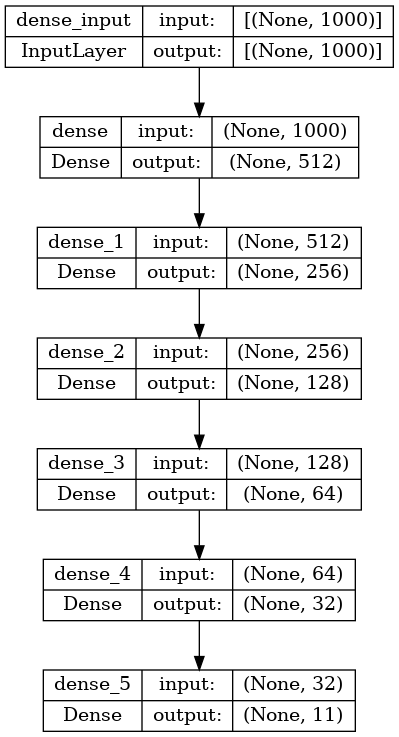

In [5]:
# Plot and save the model structure
model_structure_file = os.path.join(dir_output, 'model_structure.png')
plot_model(model, to_file=model_structure_file, show_shapes=True, show_layer_names=True)
print(f"Model structure saved to: {model_structure_file}")
display(Image(filename=model_structure_file))

# Plot the loss curve of the training process

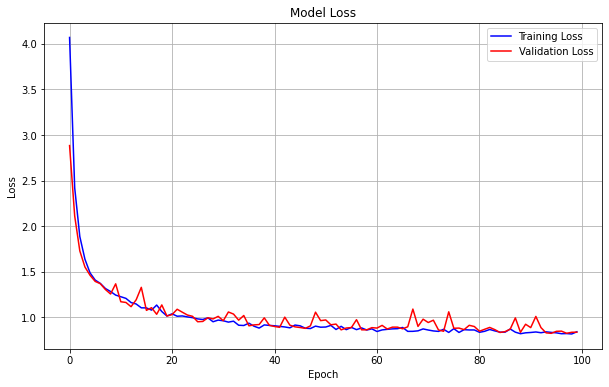

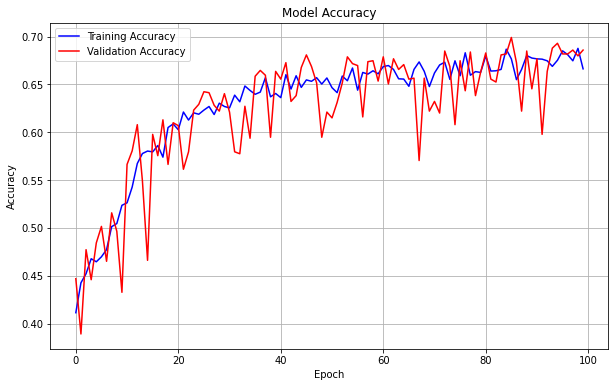

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(dir_output, 'training_loss.png'))
plt.show()
# Draw the accuracy curve during training
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(dir_output, 'training_accuracy.png'))
plt.show()


# Predict and calculate accuracy

## Prediction and Comparison:
- The trained model is loaded using `load_model` function to predict the classes for the test set (`X_test`).
- `y_test_classes`: The true class labels for the test set are adjusted based on the minimum label (`min_label`).
- `y_pred_classes`: The predicted class labels for the test set are obtained by selecting the class with the highest probability from the model's output.
  
## Accuracy Calculation:
- The accuracy of the predictions is computed using `accuracy_score` between the true and predicted class labels.

## Evaluation Metrics:
- **Mean Squared Error (MSE)**: Measures the average of the squared differences between true and predicted values.
- **R² Score**: A statistical measure of how well the predicted values approximate the true values. The closer to 1, the better the model.
- These metrics are printed and logged for further analysis.

## Save Predictions:
- The predicted class labels (`y_pred_classes`) are saved in a CSV file (`predictions.csv`) for later analysis.

## Confusion Matrix:
- A confusion matrix is generated using `confusion_matrix` to visually assess the performance of the classification model.
- The matrix is plotted using a heatmap, showing the true versus predicted values.

## Classification Report:
- A detailed classification report (`classification_report`) is generated to evaluate the precision, recall, f1-score, and support for each class.
- This report is saved as `classification_report.txt` for documentation purposes.

## Plot True vs Predicted Values:
- A plot is generated to compare the true values (`y_test_classes`) and predicted values (`y_pred_classes`) over the samples in the test set.
- The plot is saved as `true_vs_predicted.png`.

## Output Files:
- Predictions: `predictions.csv`
- Confusion Matrix: `confusion_matrix.png`
- Classification Report: `classification_report.txt`
- True vs Predicted Plot: `true_vs_predicted.png`


16/16 [==============================] - 0s 2ms/step


Test MSE: 0.422222
Test R² Score: 0.948444
Test accuracy: 0.676768


Test MSE: 0.422222
Test R² Score: 0.948444
Test accuracy: 0.676768


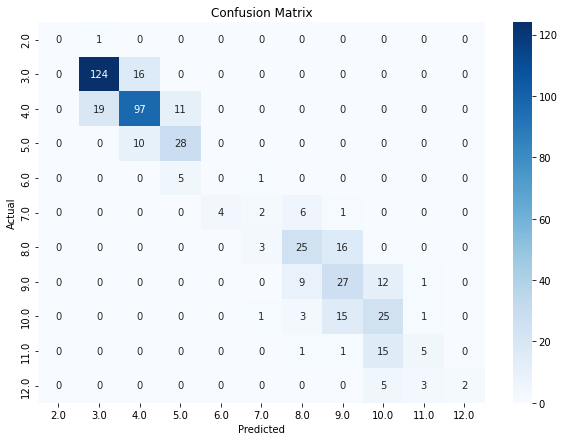

/home/dell-hd/xraylarch/envs/hanxue2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dell-hd/xraylarch/envs/hanxue2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dell-hd/xraylarch/envs/hanxue2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         1
         3.0       0.86      0.89      0.87       140
         4.0       0.79      0.76      0.78       127
         5.0       0.64      0.74      0.68        38
         6.0       0.00      0.00      0.00         6
         7.0       0.29      0.15      0.20        13
         8.0       0.57      0.57      0.57        44
         9.0       0.45      0.55      0.50        49
        10.0       0.44      0.56      0.49        45
        11.0       0.50      0.23      0.31        22
        12.0       1.00      0.20      0.33        10

    accuracy                           0.68       495
   macro avg       0.50      0.42      0.43       495
weighted avg       0.68      0.68      0.67       495



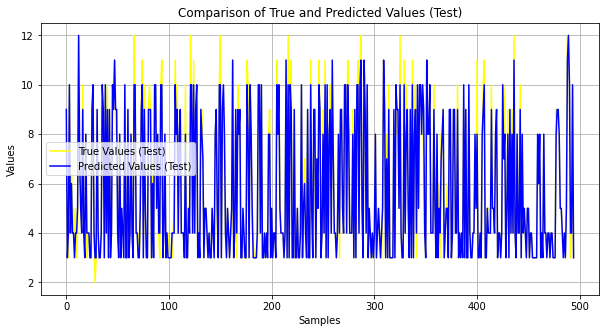

In [7]:
print(min_label)
# Predict and calculate accuracy
model = load_model(model_file)
y_test_classes = np.argmax(y_test, axis=1) + min_label 
y_pred = model.predict(X_test)
y_pred_classes  = np.argmax(y_pred, axis=1) + min_label   
test_accuracy = accuracy_score(y_test_classes, y_pred_classes)
# Calculate and print Mean Squared Error (MSE) and R² score
mse = mean_squared_error(y_test_classes, y_pred_classes)
r2 = r2_score(y_test_classes, y_pred_classes)
print(f"Test MSE: {mse:.6f}")
print(f"Test R² Score: {r2:.6f}")
logging.info(f"Test MSE: {mse:.6f}")
logging.info(f"Test R² Score: {r2:.6f}")
print(f"Test accuracy: {test_accuracy:.6f}")
logging.info(f"Test accuracy: {test_accuracy:.6f}")
#print(f'Test Accuracy: {accuracy * 100:.2f}%')
# Save predictions
np.savetxt(os.path.join(dir_output, 'predictions.csv'), y_pred_classes, delimiter=',', fmt='%d')

comparison = np.stack((y_test_classes, y_pred_classes), axis=-1)
np.savetxt(os.path.join(dir_output, 'true_vs_predicted_classification.csv'), comparison, delimiter=',', fmt='%d', header='True,Predicted')
#test_accuracy = accuracy_score(y_test_classes, y_pred_classes)
#print(f"Test accuracy: {test_accuracy:.6f}")
cm = confusion_matrix(y_test_classes, y_pred_classes)
labels = np.arange(min_label, min_label + cm.shape[0])
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(dir_output, 'confusion_matrix.png'))
plt.show()
# print the report of prediction
report = classification_report(y_test_classes, y_pred_classes)
print(report)
report_path = os.path.join(dir_output, 'classification_report.txt')
with open(report_path, 'w') as f:
    f.write(report)
plt.figure(figsize=(10, 5))
plt.plot(y_test_classes, label='True Values (Test)', color='yellow', linewidth=1.5)
plt.plot(y_pred_classes, label='Predicted Values (Test)', color='blue', linewidth=1.5)
plt.xlabel('Samples')
plt.ylabel('Values')
plt.title('Comparison of True and Predicted Values (Test)')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(dir_output, 'true_vs_predicted.png'))
plt.show()


2.0
